# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [1]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

site.config.json: 6.57kiB [00:00, 1.34MiB/s]                                                              
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (6568) does not have expected size (2289).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
collection.json: 235kiB [00:00, 34.3MiB/s]                                                                
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (234788) does not have expected size (28539).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
rdf.yaml: 3.05kiB [00:00, 1.44MiB/s]                                                                      
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (3053) does not have expected size (1218).
  warni

### 1b. Create Prediction Pipelines

In [2]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [3]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [4]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [5]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [7]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [66]:
# hpa = hpa_cyto
# hpa = hpa_endo
# hpa = hpa_mito
hpa = hpa_nucl

### 2b. Load Images

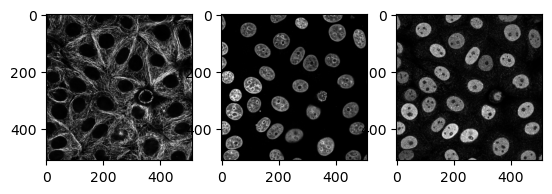

In [67]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [68]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


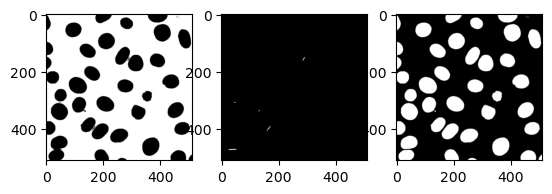

In [69]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [70]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [71]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

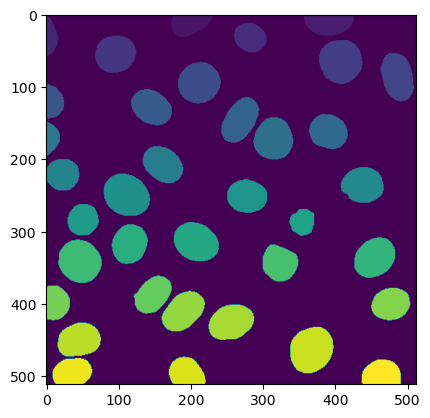

In [72]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [73]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


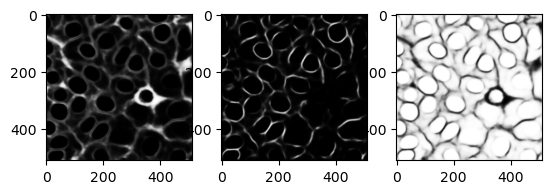

In [74]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

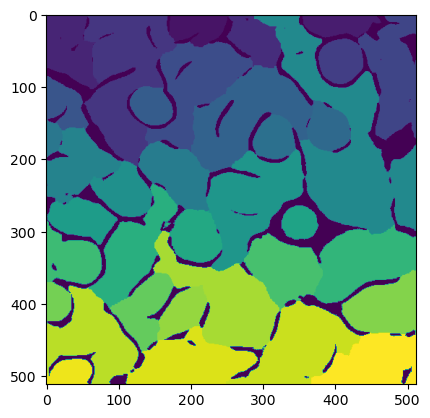

In [75]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [76]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [77]:
sizes

array([27269,  2846,  2724,  5341,  3694, 15393,  3051,  8741, 10135,
        2798,  2461, 12706,  3082,  2781,   871,  5929,  6160, 24570,
        4116, 12238,  3899,  1876,  4105,  8281,  9793,  4449,  6958,
        4771,  1603,  6366,  3188, 12028,  9272, 10779,  8684,  1846,
        7340])

# 3. Exercises and Answers

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
    - The `watershed()` function uses `bd` (boundary map) as input image data, `markers=nuclei` argument provides the seeded regions, and `mask=fg > 0.5` to restrict segmentation to the forground off the cell boundaries. Removing `mask` causes segmentation across the entire image, while removing `markers` uses random seeds, leading to a loss of nuclear segmentation.
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?
    - The cyto (cytoplasmic based) segmentation worked phenominally to segment cells. endo (endoplasmic reticulum based) did not work at all to segment, failing to define even 1 cell correctly. mito (mitochondrial based) segmented decently and resulted in a few successful cells but failed dramatically with one of the cells, also worth mentioning there were only 5 cells present to begin with which was much less than for the other samples. nucl (nuclear based) segmentation was ineffective at segmentation and although preemptively appeared promising it resulted in only 2 out of 37 cells segmented correctly. This means that cyto samples work well and mito are a distant second, with endo and nucl not qualifying as contenders in cell segmentation. 

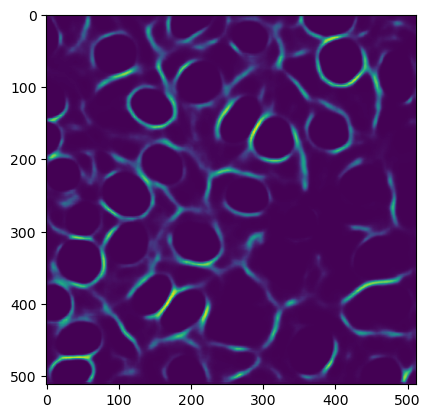

In [78]:
plt.imshow(bd)

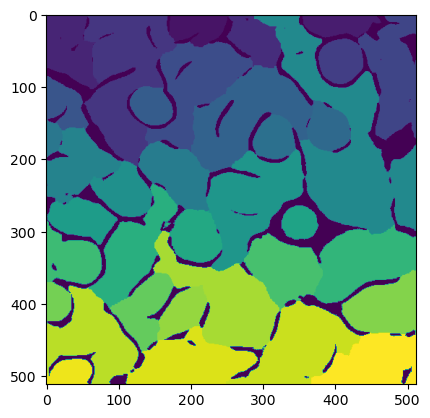

In [79]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)
# cell_seg = watershed(bd, markers=nuclei)
# cell_seg = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

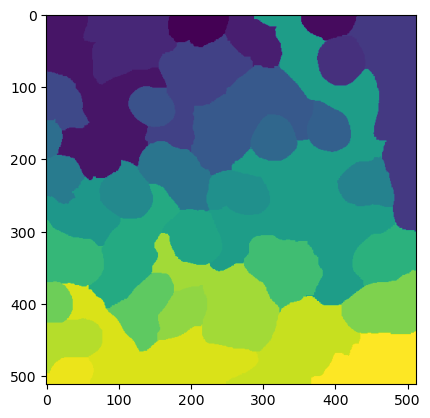

In [80]:
# cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)
cell_seg = watershed(bd, markers=nuclei)
# cell_seg = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

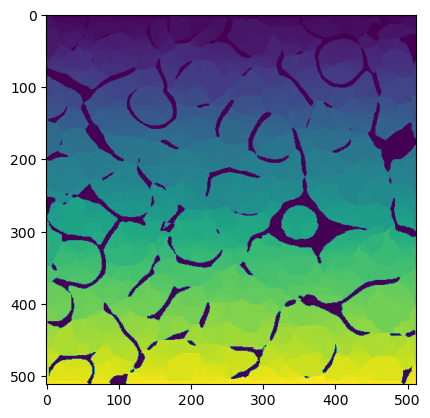

In [81]:
# cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)
# cell_seg = watershed(bd, markers=nuclei)
cell_seg = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)